# Emotional numbing as a 5PL regression model

y = d + (a-d)/(1+(x/c)^b)^g

a theortical response at min</br>
b slope factor</br>
c mid range </br>
d therotical response at max</br>
g asymetrical factor</br>

Participants will rate pictures valence.</br>
We will fit a curve to the valence rating and "known" valence based on the mean from the dataset it was taken from.</br>
Hypothesis: </br>
    1. Depressive symptoms will be correlate with "d"</br>
    2. emotional numbing symptoms will correlate with increase of "b"

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import pymc.sampling_jax as jx
import arviz as az
import jax

import matplotlib.pyplot as ply
import seaborn as sns

create a single subject

<AxesSubplot:xlabel='x', ylabel='y'>

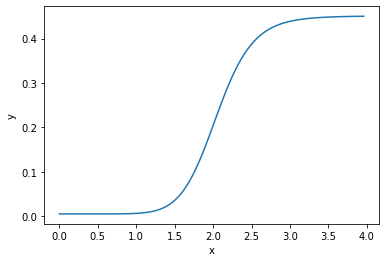

In [2]:
trials = 100
min_r = 0
max_r = 4
a = np.random.beta(1, 20, 1)[0]
b = np.random.normal(10, 2.5, 1)[0]
c = np.random.normal(2.5, .5, 1)[0]
d = np.random.beta(10, 10, 1)[0]
g = np.random.normal(1.1, .2, 1)[0]
x = np.arange(min_r, max_r, max_r/trials)
df = pd.DataFrame({'a': a,     
                   'b': b,    
                   'c': c,
                   'd': d,
                   'g': g,
                   'x': x})
df['y'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g

sns.lineplot(x='x',y='y',data=df)

In [3]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * df.x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_l = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [4]:
with pm.Model() as four_PL:
    
    a = pm.Beta('a', 2, 10)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_4 = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [93]:
with pm.Model() as five_PL:
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]
INFO:pymc:NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 550 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 550 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [92]:
with pm.Model() as five_PL_jax:
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_5_jax = pm.sampling_jax.sample_numpyro_nuts(3000, target_accept=0.95)

Compiling...
Compilation time =  0:00:02.362020
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:35.684133
Transforming variables...
Transformation time =  0:00:00.114068
Computing Log Likelihood...
Log Likelihood time =  0:00:00.657752


In [94]:
comp = az.compare({'Linear model': trace_5_jax, '5PL model':trace_5}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
5PL model,0,2324.004838,2.045623,0.000000,1.000000e+00,0.114639,0.000000,False,log
Linear model,1,1463.276511,9.787773,860.728327,3.214154e-09,0.115975,0.006916,False,log


In [6]:
comp = az.compare({'Linear model': trace_l,'4PL model': trace_4, '5PL model':trace_5}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
5PL model,0,2315.567883,1.662177,0.000000,1.000000e+00,0.115259,0.000000,False,log
4PL model,1,526.809821,4.878148,1788.758062,3.797018e-12,4.989232,4.910190,False,log
Linear model,2,129.544327,2.158871,2186.023555,0.000000e+00,4.045422,4.026501,False,log


<AxesSubplot:xlabel='Log'>

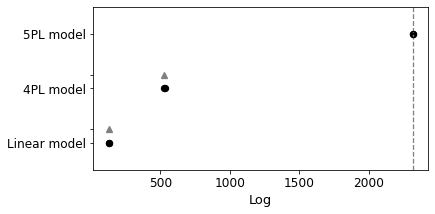

In [7]:
az.plot_compare(comp)

In [8]:
al = az.summary(trace_l, var_names=['a'])[['mean']]
bl = az.summary(trace_l, var_names=['b'])[['mean']]

df_l = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l['y'] = df_l.a + df_l.b * df_l.x

In [9]:
a4 = az.summary(trace_4, var_names=['a'])[['mean']]
b4 = az.summary(trace_4, var_names=['b'])[['mean']]
c4 = az.summary(trace_4, var_names=['c'])[['mean']]
d4 = az.summary(trace_4, var_names=['d'])[['mean']]

df_4 = pd.DataFrame({'a': a4['mean'][0],     
                     'b': b4['mean'][0],    
                     'c': c4['mean'][0],
                     'd': d4['mean'][0],
                     'x': x})

df_4['y'] = df_4.d + (df_4.a-df_4.d)/(1+(df_4.x/df_4.c)**df_4.b)

In [10]:
a5 = az.summary(trace_5, var_names=['a'])[['mean']]
b5 = az.summary(trace_5, var_names=['b'])[['mean']]
c5 = az.summary(trace_5, var_names=['c'])[['mean']]
d5 = az.summary(trace_5, var_names=['d'])[['mean']]
g5 = az.summary(trace_5, var_names=['g'])[['mean']]

df_5 = pd.DataFrame({'a': a5['mean'][0],     
                     'b': b5['mean'][0],    
                     'c': c5['mean'][0],
                     'd': d5['mean'][0],
                     'g': g5['mean'][0],
                     'x': x})

df_5['y'] = df_5.d + (df_5.a-df_5.d)/(1+(df_5.x/df_5.c)**df_5.b)**df_5.g

<AxesSubplot:xlabel='x', ylabel='y'>

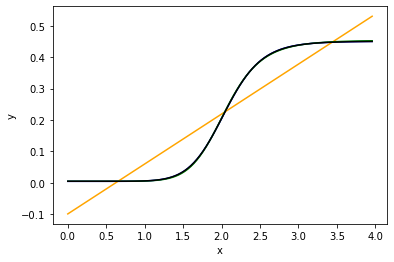

In [11]:
sns.lineplot(x='x',y='y',data=df, color = 'blue')
sns.lineplot(x='x',y='y',data=df_l, color = 'orange')
sns.lineplot(x='x',y='y',data=df_4, color = 'green')
sns.lineplot(x='x',y='y',data=df_5, color = 'black')

No noise all models work great
if we add small noise?

<AxesSubplot:xlabel='x', ylabel='y_05'>

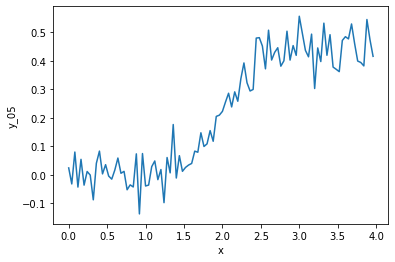

In [12]:
df['y_05'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .05, trials)

sns.lineplot(x='x',y='y_05',data=df)

In [13]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_05'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.


In [14]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_05'>

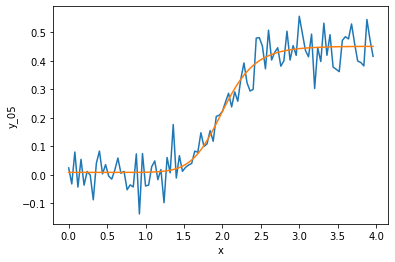

In [15]:
sns.lineplot(x='x',y='y_05',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y_1'>

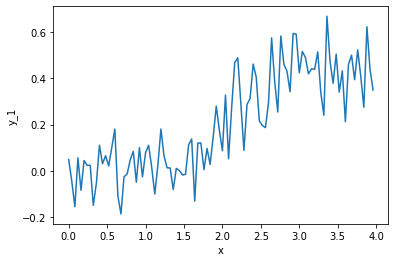

In [16]:
df['y_1'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .1, trials)

sns.lineplot(x='x',y='y_1',data=df)

In [17]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_1'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 20 seconds.


In [18]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_1'>

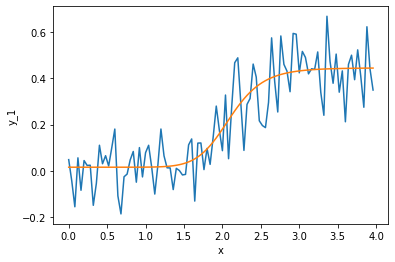

In [19]:
sns.lineplot(x='x',y='y_1',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y_2'>

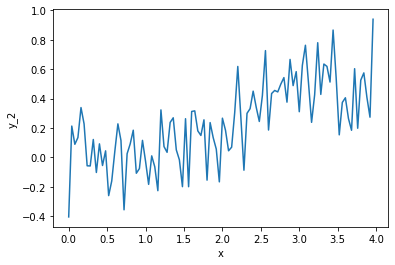

In [20]:
# Even more noise
df['y_2'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .2, trials)

sns.lineplot(x='x',y='y_2',data=df)

In [22]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_2'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


In [23]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_2'>

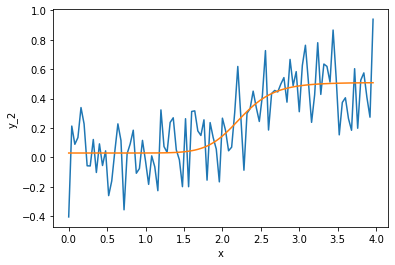

In [24]:
sns.lineplot(x='x',y='y_2',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

Can I fit a 5PL model to linear data?

<AxesSubplot:>

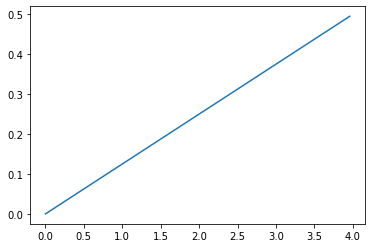

In [25]:
y = x/8
sns.lineplot(x=x,y=y)

In [26]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(x/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    
    trace_5_lin = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 189 seconds.


In [27]:
a5 = az.summary(trace_5_lin, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_lin, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_lin, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_lin, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_lin, var_names=['g'])[['mean']]

df_5_lin = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_lin['y'] = df_5_lin.d + (df_5_lin.a-df_5_lin.d)/(1+(df_5_lin.x/df_5_lin.c)**df_5_lin.b)**df_5_lin.g

In [28]:
df_5_lin.head(5)

,a,b,c,d,g,x,y
0,0.022,1.539,4.524,0.913,1.208,0.00,0.022000
1,0.022,1.539,4.524,0.913,1.208,0.04,0.022744
2,0.022,1.539,4.524,0.913,1.208,0.08,0.024158
3,0.022,1.539,4.524,0.913,1.208,0.12,0.026019
4,0.022,1.539,4.524,0.913,1.208,0.16,0.028244


<AxesSubplot:xlabel='x', ylabel='y'>

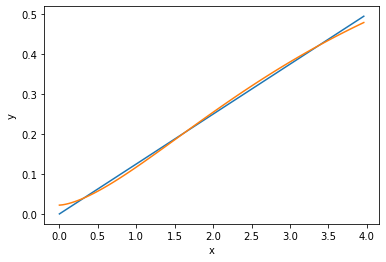

In [29]:
sns.lineplot(x=x,y=y)
sns.lineplot(x='x',y='y',data=df_5_lin)

<AxesSubplot:>

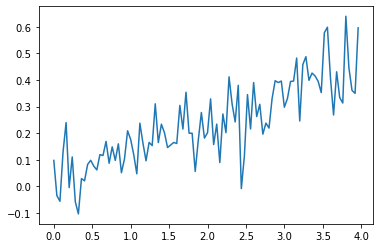

In [30]:
y = x/8 + np.random.normal(0, .1, trials)

sns.lineplot(x=x,y=y)

In [31]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(x/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    
    trace_5_lin_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 39 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [32]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    trace_l_n = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [33]:
comp = az.compare({'Linear model': trace_l_n, '5PL model':trace_5_lin_n}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Linear model,0,98.320631,3.380228,0.000000,1.0,8.224639,0.000000,False,log
5PL model,1,93.503033,5.921298,4.817598,0.0,8.129484,1.873747,False,log


In [34]:
a5 = az.summary(trace_5_lin_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_lin_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_lin_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_lin_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_lin_n, var_names=['g'])[['mean']]

df_5_lin_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_lin_n['y'] = df_5_lin_n.d + (df_5_lin_n.a-df_5_lin_n.d)/(1+(df_5_lin_n.x/df_5_lin_n.c)**df_5_lin_n.b)**df_5_lin_n.g

In [35]:
al = az.summary(trace_l_n, var_names=['a'])[['mean']]
bl = az.summary(trace_l_n, var_names=['b'])[['mean']]

df_l_n = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l_n['y'] = df_l_n.a + df_l_n.b * df_l_n.x

<AxesSubplot:xlabel='x', ylabel='y'>

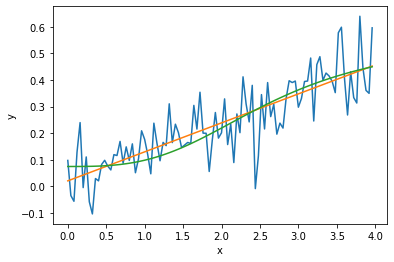

In [36]:
sns.lineplot(x=x,y=y)
sns.lineplot(x='x',y='y',data=df_l_n)
sns.lineplot(x='x',y='y',data=df_5_lin_n)

## Multi subject analysis

Create n people n/2 healthy with a linear slope and n/2 with 5 PL slope.

In [37]:
def add_sub(PTSD = 1, trials = 100, min_r = 0, max_r = 4, noise = .1):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(1, 20, 1)[0]
    c = np.random.normal(2.5, .5, 1)[0]
    d = np.random.beta(10, 10, 1)[0]
    g = np.random.normal(1.1, .2, 1)[0]
    if PTSD == 1:
        b = np.random.normal(10, 2, 1)[0]
    else:
        b = np.random.normal(8, 2, 1)[0]
        
    y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    
    for i in range(trials):
        if y[i] < 0:
            y[i]=0
    

    df = pd.DataFrame({'x': x, 'y': y})
    return(df)

<AxesSubplot:xlabel='x', ylabel='y'>

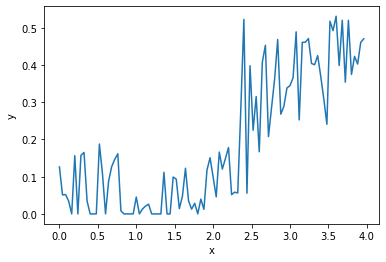

In [38]:
en_df = add_sub(PTSD=1, noise = .1)

sns.lineplot(x='x',y='y',data=en_df)

In [39]:
n_subs = 50
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub(PTSD = 1)
    temp_c = add_sub(PTSD = 0)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [40]:
with pm.Model() as linear:
    
    b_h = pm.Normal('b_h', 1, 1, shape=2)
    
    aP = pm.Normal('interceptP', 0, 5, shape = n_subs)
    bP = pm.Normal('slopeP', b_h[0], 1, shape = n_subs)
    
    aC = pm.Normal('interceptC', 0, 5, shape = n_subs)
    bC = pm.Normal('slopeC', b_h[1], 1, shape = n_subs)
    
    eps = pm.Exponential('eps', 5, shape=2)
    y_hatP = aP[sub_idxP] + bP[sub_idxP] * ptsd_df.x
    y_hatC = aC[sub_idxC] + bC[sub_idxC] * cont_df.x
       
    # Likelihood (sampling distribution) of observations
    ratingP = pm.Normal('ratingP',y_hatP, eps[0], observed=ptsd_df.y)
    ratingC = pm.Normal('ratingC',y_hatC, eps[1], observed=cont_df.y)
    
    trace_linear = pm.sample(3000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_h, interceptP, slopeP, interceptC, slopeC, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 155 seconds.


In [41]:
with pm.Model() as five_PL_ns:
    
    aC = pm.Beta('aC',   1,   20)
    bC = pm.Normal('bC', 10,  2.5)
    cC = pm.Normal('cC', 2.5, .5)
    dC = pm.Beta('dC',   10,  10)
    gC = pm.Normal('gC', 1,   .2)
    
    aP = pm.Beta('aP',   1,   20)
    bP = pm.Normal('bP', 10,  2.5)
    cP = pm.Normal('cP', 2.5, .5)
    dP = pm.Beta('dP',   10,  10)
    gP = pm.Normal('gP', 1,   .2)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatP = dP + (aP-dP)/(1+(ptsd_df['x'].values/cP)**bP)**gP
    y_hatC = dC + (aC-dC)/(1+(cont_df['x'].values/cC)**bC)**gC
    
    # Likelihood (sampling distribution) of observations
    ratingP = pm.TruncatedNormal('ratingP',y_hatP, eps[0], lower=0, observed=ptsd_df.y)
    ratingC = pm.TruncatedNormal('ratingC',y_hatC, eps[1], lower=0, observed=cont_df.y)
    trace_PL5_ns = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2117 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [42]:
with pm.Model() as five_PL:
    
    b = pm.Normal('b', 6, 3, shape=2)
    b_sd = pm.Exponential('b_sd', 5, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    
    # Likelihood (sampling distribution) of observations
    ratingP = pm.Normal('ratingP',y_hatP, eps[0], observed=ptsd_df.y)
    ratingC = pm.Normal('ratingC',y_hatC, eps[1], observed=cont_df.y)
    
    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, b_sd, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 979 seconds.


<AxesSubplot:ylabel='Count'>

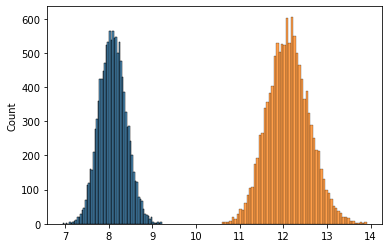

In [43]:
tr2 = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr2.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr2.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

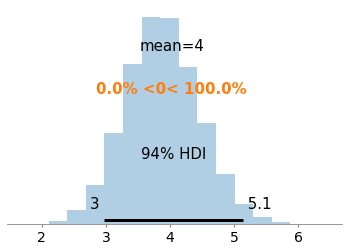

In [44]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

## If healthy participants react linearly 


In [45]:
def add_sub_l(PTSD, trials = 100, min_r = 0, max_r = 4, noise = .1):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(1, 20, 1)[0]
    c = np.random.normal(2.5, .5, 1)[0]
    d = np.random.beta(10, 10, 1)[0]
    g = np.random.normal(1.1, .2, 1)[0]

    if PTSD == 1:
        b = np.random.normal(10, 2, 1)[0]
        y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    else:
        slope = 1/8
        y = slope*x + np.random.normal(0, noise, trials)
       
    
    for i in range(trials):
        if y[i] < 0:
            y[i]=0
    

    df = pd.DataFrame({'x': x, 'y': y})
    return(df)

In [46]:
n_subs = 50
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub_l(PTSD = 1)
    temp_c = add_sub_l(PTSD = 0)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

<AxesSubplot:xlabel='x', ylabel='y'>

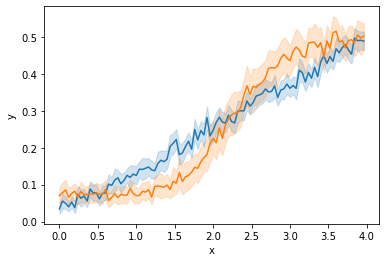

In [47]:
sns.lineplot(x='x', y='y', data=cont_df)
sns.lineplot(x='x', y='y', data=ptsd_df)

In [56]:
with pm.Model() as five_PL:
    
    b = pm.Normal('b', 6,   3, shape=2)
    c = pm.Normal('c', 2.5, 1, shape=2)
    g = pm.Normal('g', 1,   1, shape=2)
    
    # a1 = pm.TruncatedNormal('a1', 20, 1, lower = 0.1, shape=2)
    # a2 = pm.Normal('a2',         1, 10,              shape=2)
    
    # d1 = pm.Normal('d1',         10, 5,              shape=2)
    # d2 = pm.Normal('d2', 2, 10, lower = 0.1, shape=2)
    
    aC = pm.Beta('aC',   1, 20, shape = n_subs)
    bC = pm.Normal('bC', b[0],      2, shape = n_subs)
    cC = pm.Normal('cC', c[0],     .5, shape = n_subs)
    dC = pm.Beta('dC',   10, 10, shape = n_subs)
    gC = pm.Normal('gC', g[0],     .2, shape = n_subs)
    
    aP = pm.Beta('aP',   1, 20, shape = n_subs)
    bP = pm.Normal('bP', b[1],      2, shape = n_subs)
    cP = pm.Normal('cP', c[1],     .5, shape = n_subs)
    dP = pm.Beta('dP',   10, 10, shape = n_subs)
    gP = pm.Normal('gP', g[1],     .2, shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    
    # Likelihood (sampling distribution) of observations
    ratingP = pm.Normal('ratingP',y_hatP, eps[0], observed=ptsd_df.y)
    ratingC = pm.Normal('ratingC',y_hatC, eps[1], observed=cont_df.y)
    
    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, c, g, aC, bC, cC, dC, gC, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1440 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:ylabel='Count'>

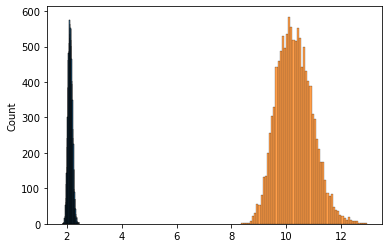

In [57]:
tr2 = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr2.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr2.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

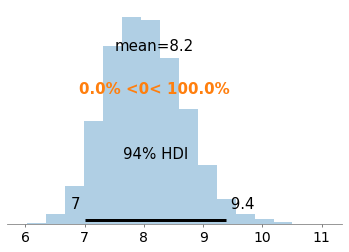

In [58]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

<AxesSubplot:xlabel='x', ylabel='y'>

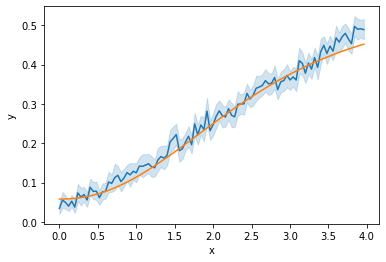

In [59]:
a5 = az.summary(trace_PL5, var_names=['aC'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bC'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cC'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dC'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gC'])[['mean']]

df_C = pd.DataFrame({'a': a5['mean'][0],
                     'b': b5['mean'][0],
                     'c': c5['mean'][0],
                     'd': d5['mean'][0],
                     'g': g5['mean'][0],
                     'x': x})

df_C['y'] = df_C.d + (df_C.a-df_C.d)/(1+(df_C.x/df_C.c)**df_C.b)**df_C.g

sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=df_C)

<AxesSubplot:xlabel='x', ylabel='y'>

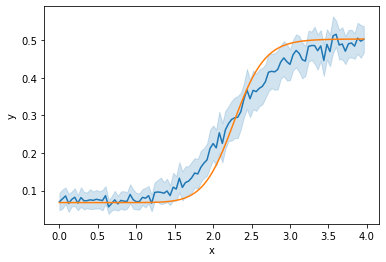

In [90]:
a5 = az.summary(trace_PL5, var_names=['aP'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bP'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cP'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dP'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gP'])[['mean']]

df_P = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': x})

df_P['y'] = df_P.d + (df_P.a-df_P.d)/(1+(df_P.x/df_P.c)**df_P.b)**df_P.g

sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_P)

In [67]:
with pm.Model() as five_PL:
        
    b = pm.Normal('b', 6, 3)
    
    aP = pm.Beta('aP',   1,   20, shape = n_subs)
    bP = pm.Normal('bP', b,    2, shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5, shape = n_subs)
    dP = pm.Beta('dP',   10,  10, shape = n_subs)
    gP = pm.Normal('gP', 1,   .2, shape = n_subs)
    
    eps = pm.Exponential('eps', 1)
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hatP, eps, observed=ptsd_df['y'])
    
    trace_5_alone = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 473 seconds.


<AxesSubplot:xlabel='x', ylabel='y'>

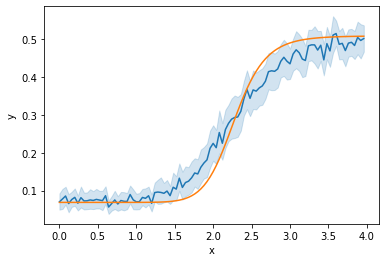

In [89]:
a5 = az.summary(trace_5_alone, var_names=['aP'])[['mean']]
b5 = az.summary(trace_5_alone, var_names=['bP'])[['mean']]
c5 = az.summary(trace_5_alone, var_names=['cP'])[['mean']]
d5 = az.summary(trace_5_alone, var_names=['dP'])[['mean']]
g5 = az.summary(trace_5_alone, var_names=['gP'])[['mean']]

df_P = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': x})

df_P['y'] = df_P.d + (df_P.a-df_P.d)/(1+(df_P.x/df_P.c)**df_P.b)**df_P.g

sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_P)

In [80]:
with pm.Model() as five_PL:
        
    b = pm.Normal('b', 6, 3)

    aP = pm.Beta('aP',    1, 20,  shape = n_subs)
    bP = pm.Normal('bP',  b, 2.5, shape = n_subs)
    cP = pm.Normal('cP',2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10, 10,  shape = n_subs)
    gP = pm.Normal('gP',  1, .2,  shape = n_subs)
    
    eps = pm.Exponential('eps', 5)
    y_hat = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=ptsd_df['y'].values)
    
    trace_5_alone = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, aP, bP, cP, dP, gP, eps]
INFO:pymc:NUTS: [b, aP, bP, cP, dP, gP, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 402 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 402 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:xlabel='x', ylabel='y'>

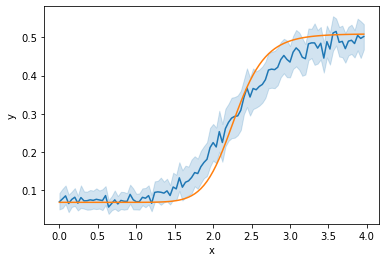

In [87]:
a5 = az.summary(trace_5_alone, var_names=['aP'])[['mean']]
b5 = az.summary(trace_5_alone, var_names=['bP'])[['mean']]
c5 = az.summary(trace_5_alone, var_names=['cP'])[['mean']]
d5 = az.summary(trace_5_alone, var_names=['dP'])[['mean']]
g5 = az.summary(trace_5_alone, var_names=['gP'])[['mean']]

df_P = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': x})

df_P['y'] = df_P.d + (df_P.a-df_P.d)/(1+(df_P.x/df_P.c)**df_P.b)**df_P.g

sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_P)

In [85]:
np.mean(az.summary(trace_5_alone, var_names=['dP'])['mean'])

0.5092